In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [3]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Unicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$

Use the Kinematics equations we had developed in class for the Unicycle model

In [5]:
#uncomment this decorator to test your code
@test 
def unicycle_model(curr_pose, v, w, dt=1.0):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x = curr_pose[0] + v*np.cos(curr_pose[2])*dt 
    y = curr_pose[1] + v*np.sin(curr_pose[2])*dt 
    theta = curr_pose[2] + w*dt 
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return (x, y, theta)

Finding tests in unicycle_model
Trying:
    unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
Expecting:
    (0.0, 0.0, 1.0)
ok
Trying:
    unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
Expecting:
    (1.0, 0.0, 1.0)
ok


Now let us try to simulate motion along a straight line and circle

Look at the kinematics equations you wrote - what should $v,\omega$ if
+ There is no change in $\theta$
+ $\theta$ has to change from 0 to 360 degrees

In [6]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
v = np.ones(steps)
w = np.zeros(steps)
for i in range(steps):
   #instruction to take v, w and compute new pose    
    straight_trajectory.append(pose) 
    pose = unicycle_model(pose,v[i],w[i])
   # store new pose
straight_trajectory = np.array(straight_trajectory)  

In [7]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps*100)
all_w = np.ones(steps*100)
for v,w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose  
    circle_trajectory.append(pose) 
    pose = unicycle_model(pose,v,w, 0.1)
   # store new pose
circular_trajectory = np.array(circle_trajectory)  


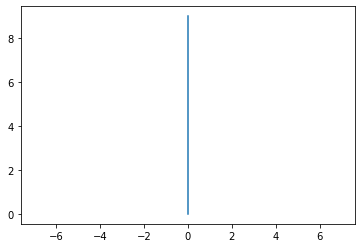

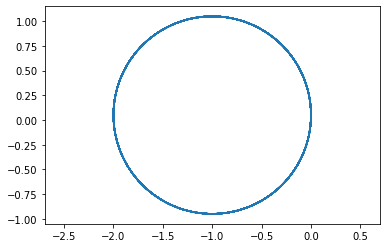

In [8]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])

plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circular_trajectory[:,0], circular_trajectory[:,1])

### Simulate Unicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\omega$. To make it even simpler, $\omega$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\omega = \omega_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\omega_c$?
* When should $\omega$ change from 0 and back?

In [9]:
v_c = 1 # m/s
w_c = np.pi/6 # rad/s (3 seconds)

#calculate time taken to finish a quarter turn (pi/2)
t_turn = int(np.pi/2/w_c)

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = 10, 5, 8

all_w = [0]*t_straight1 + [w_c]*t_turn + [0]*t_straight2 + [w_c]*t_turn + [0]*t_straight3 + [-w_c]*t_turn
all_v = v_c*np.ones_like(all_w)
print(all_w)
print(all_v)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0, 0, 0, 0, 0, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0, 0, 0, 0, 0, 0, 0, 0, -0.5235987755982988, -0.5235987755982988, -0.5235987755982988]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_w

In [29]:
def get_open_loop_commands(route, vc=1, wc=np.pi/12):
    all_w = []
    for dir, command in route: 
      if dir == 'straight':
        t_straight = int(command/vc)
        all_w += [0]*t_straight
      elif dir == 'right':
        all_w += [-wc]*int(np.deg2rad(command)/wc)
      else:
        all_w += [wc]*int(np.deg2rad(command)/wc)
    all_v = vc*np.ones_like(all_w)
    print(len(all_v))
    print(len(all_w))
    return all_v, all_w

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $w_c = \pi/12$

In [30]:
v, w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])

22
22


In [12]:
robot_trajectory = []
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose    
    robot_trajectory.append(pose) 
    pose = unicycle_model(pose,v,w)
   # store new pose
print(robot_trajectory)
print(len(robot_trajectory))
robot_trajectory = np.array(robot_trajectory)  
   # store new pose

22
22
[array([0.        , 0.        , 1.57079633]), (6.123233995736766e-17, 1.0, 1.5707963267948966), (1.2246467991473532e-16, 2.0, 1.5707963267948966), (1.8369701987210297e-16, 3.0, 1.5707963267948966), (2.4492935982947064e-16, 4.0, 1.5707963267948966), (3.061616997868383e-16, 5.0, 1.5707963267948966), (3.67394039744206e-16, 6.0, 1.3089969389957472), (0.25881904510252113, 6.965925826289069, 1.0471975511965979), (0.758819045102521, 7.831951230073507, 0.7853981633974485), (1.4659258262890682, 8.539058011260055, 0.5235987755982991), (2.3319512300735066, 9.039058011260055, 0.26179938779914974), (3.2978770563625748, 9.297877056362577, 3.3306690738754696e-16), (4.297877056362575, 9.297877056362577, 3.3306690738754696e-16), (5.297877056362575, 9.297877056362577, 3.3306690738754696e-16), (6.297877056362575, 9.297877056362577, 3.3306690738754696e-16), (7.297877056362575, 9.297877056362577, 3.3306690738754696e-16), (8.297877056362575, 9.297877056362577, 3.3306690738754696e-16), (9.2978770563625

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


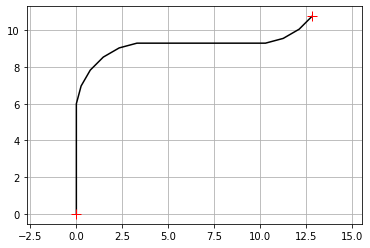

In [13]:
# plot robot trajectory
plt.figure()
plt.grid()
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1],'black')

#show first and last robot positions with + markers
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'r+', ms=10)


### Improved capabilities!

+ Slow the robot while turning ($v_c$ for turn and straight needed)

+ How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)

In [55]:
def get_open_loop_commands_turn(route, vc_s=1, vc_t = 0.5, wc=np.pi/12):
    all_w = []
    all_v = []
    for dir, command in route: 
      if dir == 'straight':
        t_straight = int(command/vc_s)
        all_w += [0]*t_straight
        all_v += [vc_s]*t_straight
      elif dir == 'right':
        all_w += [-wc]*int(np.deg2rad(command)/wc)
        all_v += [vc_t]*int(np.deg2rad(command)/wc)
      else:
        all_w += [wc]*int(np.deg2rad(command)/wc)
        all_v += [vc_t]*int(np.deg2rad(command)/wc)
    print(len(all_v))
    print(len(all_w))
    return all_v, all_w

In [60]:
robot_trajectory = []
all_v, all_w = get_open_loop_commands_turn([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],vc_s=1, vc_t = 0.5, wc=np.pi/12)
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose    
    robot_trajectory.append(pose) 
    pose = unicycle_model(pose,v,w,1)
   # store new pose
print(robot_trajectory)
print(len(robot_trajectory))
robot_trajectory = np.array(robot_trajectory)  
   # store new pose

22
22
[array([0.        , 0.        , 1.57079633]), (6.123233995736766e-17, 1.0, 1.5707963267948966), (1.2246467991473532e-16, 2.0, 1.5707963267948966), (1.8369701987210297e-16, 3.0, 1.5707963267948966), (2.4492935982947064e-16, 4.0, 1.5707963267948966), (3.061616997868383e-16, 5.0, 1.5707963267948966), (3.3677786976552215e-16, 5.5, 1.3089969389957472), (0.1294095225512607, 5.982962913144534, 1.0471975511965979), (0.37940952255126065, 6.4159756150367535, 0.7853981633974485), (0.7329629131445343, 6.7695290056300275, 0.5235987755982991), (1.1659756150367535, 7.0195290056300275, 0.26179938779914974), (1.6489385281812876, 7.148938528181288, 3.3306690738754696e-16), (2.6489385281812874, 7.148938528181288, 3.3306690738754696e-16), (3.6489385281812874, 7.148938528181288, 3.3306690738754696e-16), (4.648938528181287, 7.148938528181288, 3.3306690738754696e-16), (5.648938528181287, 7.148938528181288, 3.3306690738754696e-16), (6.648938528181287, 7.148938528181288, 3.3306690738754696e-16), (7.64893

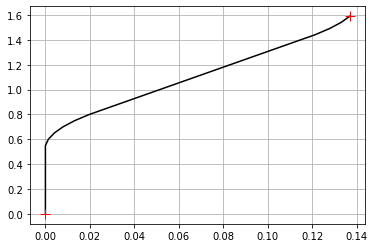

In [59]:
# plot robot trajectory
# For a sampling time of 0.1
plt.figure()
plt.grid()
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
#plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1],'black')

#show first and last robot positions with + markers
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'r+', ms=10)

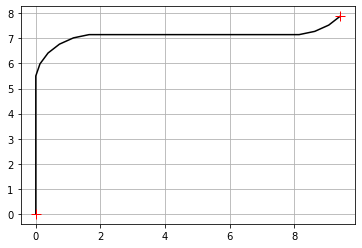

In [61]:
# plot robot trajectory
# For a sampling time of 1s
plt.figure()
plt.grid()
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
#plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1],'black')

#show first and last robot positions with + markers
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'r+', ms=10)